In [1]:
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import shutil

physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", physical_devices, len(tf.config.list_physical_devices('GPU')))
# tf.test.gpu_device_name()
device_lib.list_local_devices()








Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16459650032757090138,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5431562240
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15150718001904968020
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers


initial_lr = 1e-3 # learning rate
epochs = 40 # no of eopches to train
batch_size = 32 # batch size 
img_size = 224

print("LOADING IMAGES.......")
imagePaths = list(paths.list_images("data"))
data = []
labels =[]


#loop for the image paths
for imagePath in imagePaths:
	#extract the class label from the file
	label = imagePath.split(os.path.sep)[-2]

	#load the image
	#swap color channels and resize it
	#fixed 224*224 pixels while ingorning aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (img_size, img_size))

	#update the data and labes lists
	data.append(image)
	labels.append(label)

print("original labels: ", labels[0])
print("original labels: ", labels[-1])
# print("original labels to binary: ",labels)

#convert the data and labels to numpay
#while scalling the pixel to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)


# performs one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print("original labels to binary: ",labels[0])
print("original labels to binary: ",labels[-1])
# print("original labels to binary: ",labels)

labels = to_categorical(labels)


print("binary labels to category: ", labels[0])
print("binary labels to category: ", labels[-1])
print("binary labels to category: ", labels)

#partition the data for tranning(80%)
#and testing(20%) using splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# data_generator_with_aug = ImageDataGenerator()


data_generator_with_aug = ImageDataGenerator(
#  rotation_range=45,
#  fill_mode="nearest", 
#  horizontal_flip=True, 
 width_shift_range = 0.1, 
 height_shift_range = 0.1, 
#  shear_range=16
)

# data_generator_with_aug.fit(trainX)


# print(plt.imshow(trainX[0]))


# print(lb.classes_)

LOADING IMAGES.......
original labels:  covideff
original labels:  normaleff
original labels to binary:  [0]
original labels to binary:  [1]
binary labels to category:  [1. 0.]
binary labels to category:  [0. 1.]
binary labels to category:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [3]:
#load VGG16 network
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(img_size, img_size, 3)))
baseModel.trainable=False  # all base weight set to non-trainable
#constructing the head of the model that will be placed
#on the top of the model

headModel = baseModel.output
headModel = layers.GlobalAveragePooling2D()(headModel)
# headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
# headModel = Dense(1, activation="sigmoid")(headModel)
headModel = Dense(2, activation="softmax")(headModel)


#place the head FC model on top of the base model
#it will become the actual model will be train
model = Model(inputs=baseModel.input, outputs=headModel)

# #loop over all layers in the base model 
# for layer in baseModel.layers:
# 	layer.trainable = False

#compile our model
print("compileing model.....")
opt = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()



compileing model.....
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56,

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = "model-VGG16-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(
	filepath=model_filepath,
	monitor = 'val_accuracy',
	mode='max',
	save_best_only=True,
	verbose=1
)

#train the head of the network
print("tranning head.........")


history = model.fit(
	# x=trainX, y=trainY, batch_size= batch_size,
	data_generator_with_aug.flow(trainX, trainY, batch_size= batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data = (testX, testY),
	validation_steps = len(testX) // batch_size,
	epochs = epochs,
	callbacks=[checkpoint]
	)




tranning head.........
Epoch 1/40
50/50 [==============================] - 36s 423ms/step - loss: 0.5451 - accuracy: 0.7188 - val_loss: 0.4363 - val_accuracy: 0.8025

Epoch 00001: val_accuracy improved from -inf to 0.80250, saving model to model-VGG16-01-0.8025.h5
Epoch 2/40
50/50 [==============================] - 11s 211ms/step - loss: 0.4384 - accuracy: 0.8050 - val_loss: 0.4087 - val_accuracy: 0.8200

Epoch 00002: val_accuracy improved from 0.80250 to 0.82000, saving model to model-VGG16-02-0.8200.h5
Epoch 3/40
50/50 [==============================] - 10s 207ms/step - loss: 0.3916 - accuracy: 0.8331 - val_loss: 0.3627 - val_accuracy: 0.8350

Epoch 00003: val_accuracy improved from 0.82000 to 0.83500, saving model to model-VGG16-03-0.8350.h5
Epoch 4/40
50/50 [==============================] - 10s 203ms/step - loss: 0.3550 - accuracy: 0.8494 - val_loss: 0.3152 - val_accuracy: 0.8750

Epoch 00004: val_accuracy improved from 0.83500 to 0.87500, saving model to model-VGG16-04-0.8750.h5


evaluating network.....
True positive =  194
True negative =  185
False positive =  15
False negative =  6
[[185  15]
 [  6 194]]
accurancy: 0.9475
precision: 0.9250
sensitivity: 0.9686
specificity: 0.9282
f1-score: 0.9463


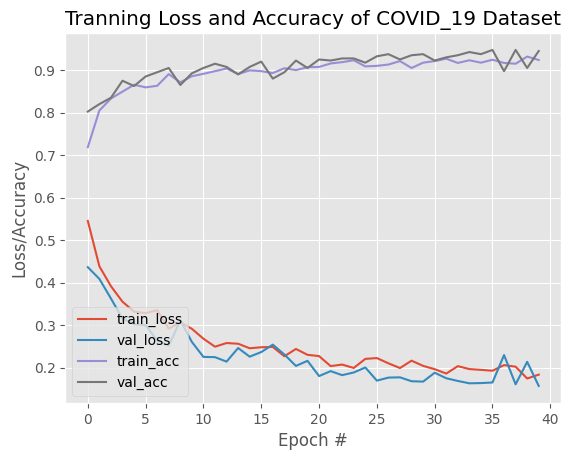

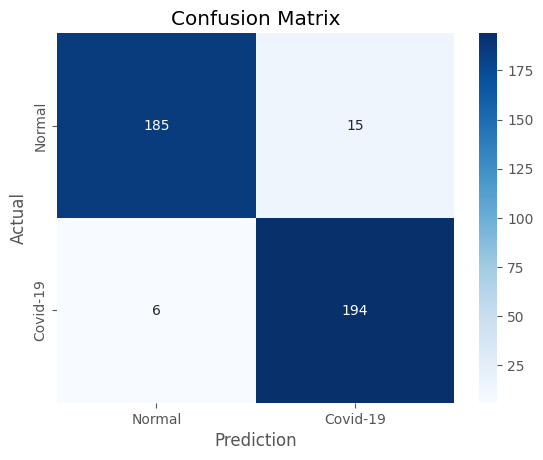

In [5]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

model_name = 'model-VGG16-36-0.9475'
model = load_model(model_name + '.h5')
# make predications on the testing set
print("evaluating network.....")

predIdxs = model.predict(testX, batch_size=batch_size)


# for each image in the testing set we need 
# to find the the index of the label with 
# corresponding largest predicated probability
predIdxs = np.argmax(predIdxs, axis=1)
# testY original is [1. 0.] testY.argmax(axis=1) let 
# [1. 0.] become 0
# [0. 1.] become 1

import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = model_name + '_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = model_name + '_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# show a nicely formatted classification report

# print(classification_report(testY.argmax(axis=1), predIdxs,
# 	target_names=lb.classes_))

### lb.classes_ = covideff normaleff



# compute the confusion matrix nad use it 
# to drive the raw accuracy, sensitivity 
# and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)

tp = cm[1,1]
tn = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]

print('True positive = ', tp)
print('True negative = ', tn)
print('False positive = ', fp)
print('False negative = ', fn)

total_test = sum(sum(cm))
accurancy = (cm[0, 0] + cm[1, 1]) / total_test	### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[0, 0] / (cm[0, 0] + cm[1, 0])	### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1])	### Specificity (true negatives / all actual negatives) =TN / TN + FP
f1score = 2*(precision*sensitivity)/(precision+sensitivity)




# show the cnfusion matrix, accuracy with 4 digits
#sensitivity, and specificity
print(cm)
print("accurancy: {:.4f}".format(accurancy))
print("precision: {:.4f}".format(precision))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
print("f1-score: {:.4f}".format(f1score))


# plot the tranning loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")	
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")	
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")	
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Tranning Loss and Accuracy of COVID_19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()


import seaborn as sns
### fmt ='g' to turn off scientific number 
sns.heatmap(cm, cmap="Blues",annot=True, fmt='g',xticklabels=["Normal", "Covid-19"], yticklabels=["Normal", "Covid-19"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()



# plt.plot(np.arange(0, epochs), history.history['auc'], label='AUC')
# plt.plot(np.arange(0, epochs), history.history['val_auc'], label='Val_AUC')
# plt.xlabel('No.of epochs')
# plt.ylabel('AUC')
# plt.title('Training and validation AUC')
# plt.legend(loc="lower left")


#fn here: actual is 0(covideff) but identify to 1(normalleff) 0-->1: 7 0-->0:73
# for current confusion matrix become:
# original labels:  covideff
# original labels:  normaleff
# original labels to binary:  [0]
# original labels to binary:  [1]
# binary labels to category:  [1. 0.]
# binary labels to category:  [0. 1.]
# normaleff:	tn fp
# covideff:	fn tp


## confusion matrix (normally online is like below, my diff with online)
## tp fp
## fn tn

### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
### Misclassification (all incorrect / all) = FP + FN / TP + TN + FP + FN
### Precision (true positives / predicted positives) = TP / TP + FP
### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
### Specificity (true negatives / all actual negatives) =TN / TN + FP


